In [1]:
# creat all figures
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import matplotlib.patches as mpatches
from matplotlib import rc
# import latex
rc("text", usetex=False)

Plot RMSE from cross validation

In [2]:
%load_ext autoreload
%autoreload 2
from basic.plot import plot_error_cv

plt.rcParams["text.usetex"] = False
sns.set_style('darkgrid')

In [3]:
def df_return(fp, fn):
    error_stats = pd.read_csv(f'{fp}{fn}', index_col = 'index')
    cols = error_stats.columns
    error_stats.loc[:, cols[1]] = error_stats.loc[:, cols[0]] - error_stats.loc[:, cols[1]]
    error_stats.loc[:, cols[2]] = error_stats.loc[:, cols[2]] - error_stats.loc[:, cols[0]]  
    df_temp = error_stats.iloc[:]
    
    return df_temp


In [11]:
# Plot errors of cross-validation
from matplotlib import rcParams

filepath = ['../output/paper0915/', '../output/paper0915/figure4/test_plot/', '../output/paper0915/figure4/test1013/']
filename = ['error_cv_uniform_552.csv', 'error_cv_beta_552.csv']
filename_22 = 'error_cv_compare.csv'

error_stats = pd.read_csv(f'{filepath[0]}{filename_22}').iloc[0]

df_uniform = df_return(filepath[1], filename[0])
cols = df_uniform.columns
df_uniform.rename(columns={col: col+'_uni' for col in cols}, inplace=True)
df_beta = df_return(filepath[1], filename[1])
df_beta.rename(columns={col: col+'_beta' for col in cols}, inplace=True)
df = pd.concat([df_uniform, df_beta], axis=1)
df.loc['nsample_552', 'mean_22_uni'] = error_stats['mean']
# df.loc['nsample_552', 'mean_22_uni'] = error_stats['mean']
df.loc['nsample_552', 'lower_22_uni'] = error_stats['mean'] - error_stats['lower']
df.loc['nsample_552', 'upper_22_uni'] = error_stats['upper'] - error_stats['mean']

# error_stats = pd.read_csv(f'{filepath[1]}{filename_22}').iloc[0]

df_uniform = df_return(filepath[2], filename[0])
df_uniform.rename(columns={col: col+'_uni' for col in cols}, inplace=True)
df_beta = df_return(filepath[2], filename[1])
df_beta.rename(columns={col: col+'_beta' for col in cols}, inplace=True)
df_allsamples = pd.concat([df_uniform, df_beta], axis=1)
df_allsamples.loc['nsample_552', 'mean_22_uni'] = error_stats['mean']
# df.loc['nsample_552', 'mean_22_uni'] = error_stats['mean']
df_allsamples.loc['nsample_552', 'lower_22_uni'] = error_stats['mean'] - error_stats['lower']
df_allsamples.loc['nsample_552', 'upper_22_uni'] = error_stats['upper'] - error_stats['mean']

df_cols = df.columns
keys = ['legend', 'legend_low', 'legend_up']
legend_dict = {}
for ind in range(len(keys)):
    legend_dict[keys[ind]] = [df_cols[i] for i in range(len(df_cols)) if (i % 3) ==ind]

df = df.reset_index()
df_allsamples = df_allsamples.reset_index()
# plt.savefig(f'{filepath}/figure/pce_compare.png', format='png', dpi=300)

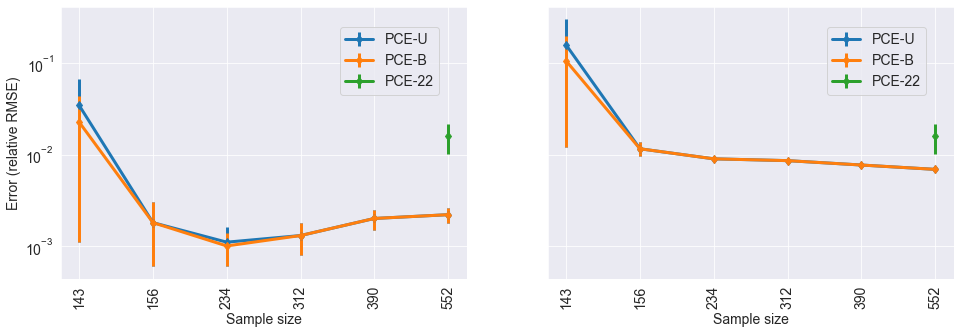

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 5))
ax1 = df.plot(x='index', y=legend_dict['legend'], kind='line', marker='d',
                yerr=df.loc[:, [*legend_dict['legend_low'], *legend_dict['legend_up']]].T.values, 
                legend=True, logy=True, xticks=np.arange(df.shape[0]), ax=axes[0])

ax1.set_xticklabels(labels = [143, 156, 234, 312, 390, 552], fontsize = 14, rotation=90);
rcParams['ytick.labelsize'] = 14
ax1.legend(['PCE-U', 'PCE-B', 'PCE-22'], bbox_to_anchor=(0.95, 0.95), fontsize=14)
ax1.set_ylabel('Error (relative RMSE)', fontsize = 14);
ax1.set_xlabel('Sample size', fontsize = 14);

ax2 = df_allsamples.plot(x='index', y=legend_dict['legend'], kind='line', marker='d',
                yerr=df_allsamples.loc[:, [*legend_dict['legend_low'], *legend_dict['legend_up']]].T.values, 
                legend=True, logy=True, xticks=np.arange(df_allsamples.shape[0]), ax=axes[1])

ax2.set_xticklabels(labels = [143, 156, 234, 312, 390, 552], fontsize = 14, rotation=90);
rcParams['ytick.labelsize'] = 14
ax2.legend(['PCE-U', 'PCE-B', 'PCE-22'], bbox_to_anchor=(0.95, 0.95), fontsize=14)
ax2.set_ylabel('Error (relative RMSE)', fontsize = 14);
ax2.set_xlabel('Sample size', fontsize = 14);
plt.savefig(f'{filepath}/figure/pce_compare.png', format='png', dpi=300)

## Bar plot of sensitivity indices

In [29]:
# sensitivity plot
filepath = '../output/paper/'
df_plot = pd.read_csv(f'{filepath}sa_fig2.csv', index_col= 'Unnamed: 0')

sns.set_style('white')
current_palette = sns.color_palette()
# sns.set_color_codes(current_palette)
fig = plt.figure(figsize=(8, 6))
colors = list(np.where(df_plot.Type_num == 0, 0, 2))
colors = [current_palette[c] for c in colors]
ax = df_plot.plot(x='short_name', y='ST', kind='bar', 
                yerr='ST_conf', color=colors, legend=False, logy=False)
ax.set_ylabel('Total effects', fontsize=10)
ax.set_xlabel('Parameters', fontsize=10)
ax.tick_params(axis='x', which='major', labelsize=8)
index = [0, 20, 28]
xmin, ymin = [-0.3, 19.5, 27.5], 0
height, width = 0.79, [9.8, 3, 3]
for i  in range(len(index)):
    ax.add_patch(
        mpatches.Rectangle(
            xy=(xmin[i], ymin),  # point of origin.
            width=width[i],
            height=height,
            linewidth=1,
            color=current_palette[1],
            fill=False,
            linestyle='--'
        )
)   
SPL = mpatches.Patch(color=current_palette[0], label='Sampling')
PCE_Beta = mpatches.Patch(color=current_palette[2], label='PCE')
ax.legend(handles=[SPL, PCE_Beta], fontsize=8, loc=9) 
# plt.savefig(f'{filepath}figure/sentivity_fig1.png', format='png', dpi=300, bbox_inches='tight')

AttributeError: 'DataFrame' object has no attribute 'Type_num'

In [50]:
df_plot

,Parameters,ST,ST_conf_lower,ST_conf_upper,ST_Beta,ST_Beta_conf_lower,ST_Beta_conf_upper,ST_Uniform,ST_Uniform_conf_lower,ST_Uniform_conf_upper,short_name
0,bankErosionCoeff,0.621704,0.059881,0.061024,0.616205,0.007981,0.009458,0.870492,0.012857,0.012030,BEC-R
7,Beta,0.209298,0.025889,0.027194,0.207556,0.006839,0.007490,0.047646,0.006924,0.006575,Beta
3,RiparianVegPercent,0.069010,0.009944,0.011385,0.066703,0.003752,0.004071,0.052183,0.006513,0.006830,RVP
2,HillslopeFineSDR,0.047440,0.006181,0.006898,0.046282,0.003168,0.003611,0.016259,0.003610,0.004218,HFSDR-R
4,USLE_HSDR_Fine,0.041086,0.005565,0.006151,0.041181,0.002766,0.003136,0.009188,0.001998,0.002020,USLEHF
8,LongTermAvDailyFlow,0.018078,0.003256,0.003805,0.018440,0.002026,0.002458,0.015110,0.003483,0.003706,LTADF
1,eventMeanConcentration,0.015176,0.002801,0.003189,0.014956,0.001890,0.002290,0.003472,0.000970,0.001225,EMC
6,RainThreshold,0.000798,0.000357,0.000576,0.000803,0.000361,0.000554,0.000218,0.000135,0.000368,RT
5,A3,0.000344,0.000244,0.000505,0.000361,0.000248,0.000557,0.000190,0.000153,0.000378,A3
9,Gully_Management_Practice_Factor,0.000314,0.000230,0.000498,0.000320,0.000225,0.000592,0.000247,0.000199,0.000598,GMPF-R


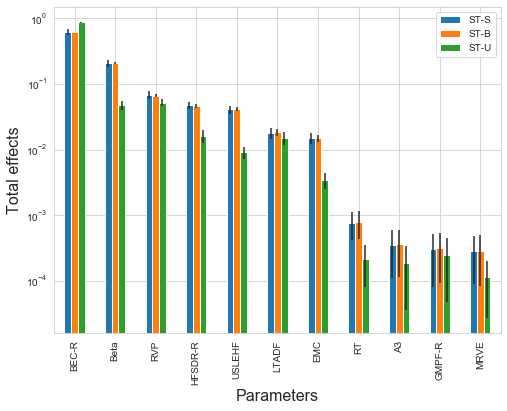

In [4]:
# plot sensitivity for PCE with 11 parameters of Beta, Uniform dists
filepath = '../output/paper0915/'
df_plot = pd.read_csv(f'{filepath}sa_fig2.csv', index_col= 'Unnamed: 0')
cols = df_plot.columns
legend = ['ST', 'ST_Beta', 'ST_Uniform']
legend_low = [lab+'_conf_lower' for lab in legend]
legend_up = [lab+'_conf_upper' for lab in legend]
for lab in legend:
    df_plot.loc[:, f'{lab}_conf_lower'] = df_plot.loc[:, lab] - df_plot.loc[:, f'{lab}_conf_lower'] 
    df_plot.loc[:, f'{lab}_conf_upper'] = df_plot.loc[:, f'{lab}_conf_upper'] - df_plot.loc[:, lab]

sns.set_style('whitegrid')
ax = df_plot.plot(x='short_name', y=legend, kind='bar', figsize=(8,6),
                yerr=df_plot.loc[:, [*legend_low, *legend_up]].T.values, 
                legend=True, logy=True, xticks=np.arange(df_plot.shape[0]))
ax.set_ylabel('Total effects', fontsize=16);
ax.set_xlabel('Parameters', fontsize=16); 
ax.set_xticklabels(df_plot.short_name.values, rotation=90);
ax.legend(['ST-S', 'ST-B', 'ST-U'])
plt.savefig(f'{filepath}figure/Figure5-log-bar.png', format='png', dpi=300, bbox_inches='tight') 

In [8]:
df_plot

,Parameters,ST,ST_conf_lower,ST_conf_upper,ST_Beta,ST_Beta_conf_lower,ST_Beta_conf_upper,ST_Uniform,ST_Uniform_conf_lower,ST_Uniform_conf_upper,short_name
0,bankErosionCoeff,0.762550,0.099928,0.114356,0.759594,0.007180,0.006195,0.916264,0.007124,0.006454,new_BEC
3,RiparianVegPercent,0.085721,0.016571,0.017165,0.081979,0.003982,0.004238,0.054049,0.005774,0.006282,RVP
7,Beta,0.063841,0.011290,0.016928,0.062540,0.003493,0.003249,0.010991,0.001943,0.002280,Beta
4,USLE_HSDR_Fine,0.051351,0.008921,0.010443,0.052003,0.002840,0.003244,0.008928,0.001611,0.001836,USLEHF
8,LongTermAvDailyFlow,0.021809,0.004800,0.005501,0.022328,0.002341,0.002537,0.015533,0.002794,0.002902,LTADF
1,eventMeanConcentration,0.018327,0.003653,0.004227,0.018395,0.002125,0.002027,0.003321,0.000877,0.000982,EMC
2,HillslopeFineSDR,0.015537,0.003284,0.003620,0.015739,0.001800,0.002105,0.005837,0.001841,0.002282,new_HFSDR
6,RainThreshold,0.000891,0.000350,0.000502,0.000921,0.000345,0.000449,0.000175,0.000093,0.000261,RT
5,A3,0.000307,0.000213,0.000504,0.000292,0.000190,0.000387,0.000143,0.000116,0.000323,A3
9,Gully_Management_Practice_Factor,0.000303,0.000217,0.000443,0.000305,0.000212,0.000390,0.000176,0.000137,0.000406,new_GMPF


## Plot Figure 7

In [11]:
# calculate the changes in the confidence intervals
# heat map 
filepath = '../output/paper0915/error_measures/1021_cal/'
filename = ['cf_width', 'cf_width_lower', 'cf_width_upper']
df_mean = pd.read_csv(f'{filepath}{filename[0]}.csv', index_col = 'Unnamed: 0')
df_lower = pd.read_csv(f'{filepath}{filename[1]}.csv', index_col = 'Unnamed: 0')
df_upper = pd.read_csv(f'{filepath}{filename[2]}.csv', index_col = 'Unnamed: 0')
df_lower = 1 - df_lower
cols = df_mean.columns
for col in cols:
    ind = df_mean[df_mean[col]>1].index.tolist()
    if len(ind) > 0: df_lower.loc[ind, col] = 1 - df_upper.loc[ind, col]
df_lower.to_csv(f'{filepath}cf_changes.csv', index=True)

Line plot for three error measures

In [14]:
# prepare the data for plot: confidence intervals and the coefficient of variation
filepath = '../output/paper0915/error_measures/1021_cal/'
filename = ['cf_upper', 'cf_lower', 'cv', 'ks', 'pvalue', 'cf_upper_upper', 
'cf_upper_lower', 'cf_lower_upper', 'cf_lower_lower',
'ks_lower', 'ks_upper', 'pvalue_lower', 'pvalue_upper', 'cond_mean']

# get data in the corresponding column
num_params = 11
col_filter = ['nsample_156']
df = pd.DataFrame(index=np.arange(num_params), columns=filename)
x_range = [0, num_params + 1]
for f in filename:
    df[f] = pd.read_csv(f'{filepath}{f}.csv').loc[:, col_filter]
df.index = np.arange(df.shape[0], 0, -1)
df.index.name = 'Num of parameters fixed'
df.reset_index(inplace=True)
# add the one with no parameter fixed

In [15]:
# add the relative change of CIs formed as the deviation to median
cf_median = (df.loc[:, 'cf_upper'] + df.loc[:, 'cf_lower']) / 2
df.loc[:, 'upper_mean'] = (df.cf_upper - df.cond_mean) / df.cond_mean
df.loc[:, 'upper_mean_lower'] = (df.cf_upper_lower - df.cond_mean) / df.cond_mean
df.loc[:, 'upper_mean_upper'] = (df.cf_upper_upper - df.cond_mean) / df.cond_mean
df.loc[:, 'lower_mean'] = (df.cond_mean - df.cf_lower) / df.cond_mean
df.loc[:, 'lower_mean_lower'] = (df.cond_mean - df.cf_lower_lower) / df.cond_mean
df.loc[:, 'lower_mean_upper'] = (df.cond_mean - df.cf_lower_upper) / df.cond_mean
df.loc[:, 'cf_median_mean'] = (cf_median - df.cf_lower) / cf_median
df.loc[:, 'cf_median_lower'] = (cf_median - df.cf_lower_lower) / cf_median
df.loc[:, 'cf_median_upper'] = (cf_median - df.cf_lower_upper) / cf_median
df.loc[:, 'cf_cv'] = 2 * df['cv']

In [16]:
df

,Num of parameters fixed,cf_upper,cf_lower,cv,ks,pvalue,cf_upper_upper,cf_upper_lower,cf_lower_upper,cf_lower_lower,...,upper_mean,upper_mean_lower,upper_mean_upper,lower_mean,lower_mean_lower,lower_mean_upper,cf_median_mean,cf_median_lower,cf_median_upper,cf_cv
0,11,2.774412e+07,2.774412e+07,0.000000,0.569949,9.313839e-128,2.774412e+07,2.774412e+07,2.774412e+07,2.774412e+07,...,0.000000,-5.370927e-16,-5.370927e-16,0.000000,5.370927e-16,5.370927e-16,0.000000,5.370927e-16,5.370927e-16,0.000000
1,10,3.551139e+07,2.268334e+07,0.073226,0.125373,5.245996e-06,3.619039e+07,3.480993e+07,2.281706e+07,2.250628e+07,...,0.280043,2.547582e-01,3.045184e-01,0.182356,1.887387e-01,1.775366e-01,0.220433,2.265182e-01,2.158377e-01,0.146452
2,9,3.550482e+07,2.026505e+07,0.109705,0.052779,1.585812e-01,3.609822e+07,3.478045e+07,2.073815e+07,1.977936e+07,...,0.302194,2.756264e-01,3.239577e-01,0.256748,2.745615e-01,2.393965e-01,0.273262,2.906793e-01,2.562956e-01,0.219411
3,8,3.595229e+07,2.016846e+07,0.124674,0.043543,3.312289e-01,3.693637e+07,3.533969e+07,2.076918e+07,1.968614e+07,...,0.318588,2.961203e-01,3.546804e-01,0.260300,2.779900e-01,2.382684e-01,0.281248,2.984362e-01,2.598395e-01,0.249349
4,7,3.595229e+07,2.016846e+07,0.124674,0.043543,3.312289e-01,3.693637e+07,3.533969e+07,2.076918e+07,1.968614e+07,...,0.318588,2.961203e-01,3.546804e-01,0.260300,2.779900e-01,2.382684e-01,0.281248,2.984362e-01,2.598395e-01,0.249349
5,6,3.588195e+07,2.008802e+07,0.142293,0.027447,8.246941e-01,3.697010e+07,3.513454e+07,2.048566e+07,1.960875e+07,...,0.316139,2.887241e-01,3.560521e-01,0.263178,2.807571e-01,2.485923e-01,0.282186,2.993119e-01,2.679769e-01,0.284586
6,5,3.588195e+07,2.008802e+07,0.142293,0.027447,8.246941e-01,3.697010e+07,3.513454e+07,2.048566e+07,1.960875e+07,...,0.316139,2.887241e-01,3.560521e-01,0.263178,2.807571e-01,2.485923e-01,0.282186,2.993119e-01,2.679769e-01,0.284586
7,4,3.616092e+07,1.996028e+07,0.157008,0.014235,9.994658e-01,3.738695e+07,3.526985e+07,2.045240e+07,1.951941e+07,...,0.325372,2.927122e-01,3.703082e-01,0.268415,2.845738e-01,2.503777e-01,0.288672,3.043839e-01,2.711347e-01,0.314015
8,3,3.616092e+07,1.996028e+07,0.157008,0.014235,9.994658e-01,3.738695e+07,3.526985e+07,2.045240e+07,1.951941e+07,...,0.325372,2.927122e-01,3.703082e-01,0.268415,2.845738e-01,2.503777e-01,0.288672,3.043839e-01,2.711347e-01,0.314015
9,2,3.614865e+07,1.995291e+07,0.156195,0.011246,9.999682e-01,3.739762e+07,3.521146e+07,2.047219e+07,1.949056e+07,...,0.325246,2.908873e-01,3.710340e-01,0.268506,2.854567e-01,2.494693e-01,0.288686,3.051688e-01,2.701741e-01,0.312390


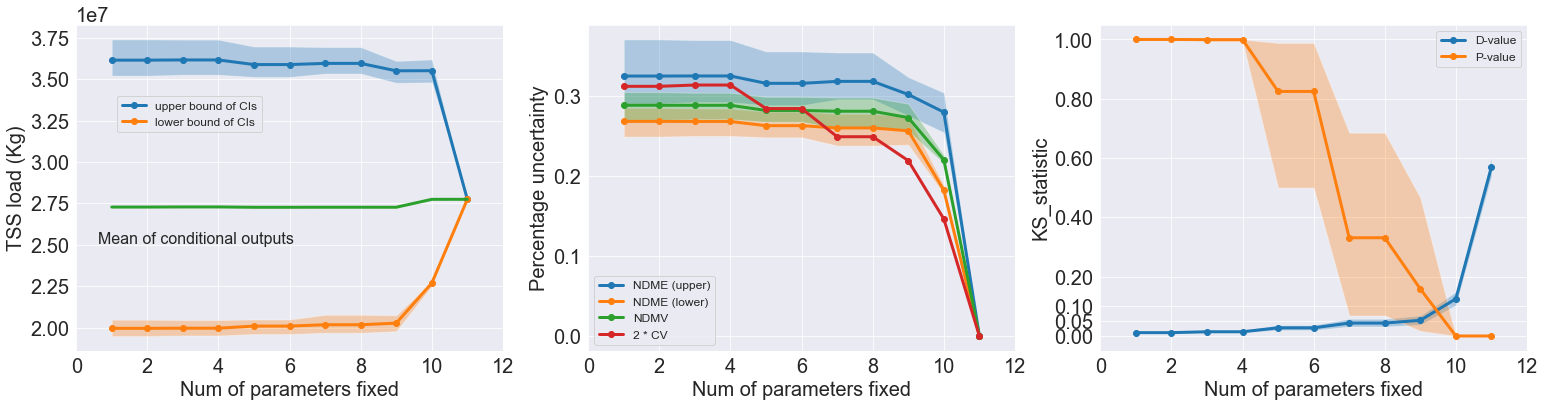

In [18]:
# Line plot
plt.rcParams["text.usetex"] = False
sns.set_style('darkgrid')
fs = 12
fig, axes = plt.subplots(1, 3, sharex=True)
x_col = 'Num of parameters fixed'
ax = df.plot(x=x_col, y=filename[0:2], 
            figsize=(26, 6), marker='o', ax=axes[0])
ax.fill_between(df.loc[:, x_col], df.cf_upper_lower, df.cf_upper_upper, alpha=0.3)
ax.fill_between(df.loc[:, x_col], df.cf_lower_lower, df.cf_lower_upper, alpha=0.3)            
             
ax.plot(df.loc[:, x_col], df.cond_mean)          
# ax.axhline(c='grey',linestyle='--', y=y_uncond_stat['cf_upper']) 
ax.text(0.05, 0.33, 'Mean of conditional outputs', transform=ax.transAxes) #c='k',

ax.set_ylabel('TSS load (Kg)')
ax.legend(['upper bound of CIs', 'lower bound of CIs'], fontsize=fs, bbox_to_anchor=(0.45, 0.8))

ax1 = df.plot(x_col, ['upper_mean', 'lower_mean', 'cf_median_mean', 'cf_cv'], marker='o', ax=axes[1])
ax1.fill_between(df.loc[:, x_col], df.upper_mean_lower, df.upper_mean_upper, alpha=0.3)
ax1.fill_between(df.loc[:, x_col], df.lower_mean_lower, df.lower_mean_upper, alpha=0.3)
ax1.fill_between(df.loc[:, x_col], df.cf_median_lower, df.cf_median_upper, alpha=0.3)
ax1.set_ylabel('Percentage uncertainty') 
ax1.legend(['NDME (upper)', 'NDME (lower)', 'NDMV', '2 * CV'], fontsize=fs)

ax2 = df.plot(x_col,['ks', 'pvalue'], marker='o', ax=axes[2])
ax2.fill_between(df.loc[:, x_col], df.ks_lower, df.ks_upper, alpha=0.3)
ax2.fill_between(df.loc[:, x_col], df.pvalue_lower, df.pvalue_upper, alpha=0.3)
ax2.set_xlim(*x_range)
ax2.set_yticks([0, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0])
ax2.set_ylabel('KS_statistic')
ax2.legend(['D-value', 'P-value'], fontsize=fs) ;
ax2.set_xlabel(x_col);
# fpath_save = '../output/paper0915/figure/'
plt.savefig(f'{filepath}/figure7_uncertainty_communication.png', format='png', dpi=300, bbox_inches='tight')

Line plot for showing robustness of error estimation

In [3]:
# Adaptive evaluation of error measure
filepath = '../output/paper0915/error_measures/'
filename = ['cf_lower_adaptive', 'cf_lower_lower_adaptive', 'cf_lower_upper_adaptive',
            'cf_upper_adaptive', 'cf_upper_lower_adaptive', 'cf_upper_upper_adaptive',             'stats_uncond_adaptive']

In [10]:
# sort the dataframe for plot
df = pd.DataFrame()
for fn in filename[:-1]:
    df[fn] = pd.read_csv(f'{filepath}{fn}.csv', index_col = 'Unnamed: 0').iloc[2]
df.loc[:, 'median'] = (df.loc[:, filename[0]] + df.loc[:, filename[3]]) / 2 # only use the mean of CIs for calculation
cols = df.columns

In [11]:
df_ratio = pd.DataFrame(index=df.index, columns=df.columns)
for fn in filename[:-1]:
    if 'cf_lower' in fn:
        df_ratio.loc[:, fn] = (df.loc[:, cols[-1]] - df.loc[:, fn]) / df.loc[:, cols[-1]]
    else:
        df_ratio.loc[:, fn] = (df.loc[:, fn] - df.loc[:, cols[-1]]) / df.loc[:, cols[-1]]
df_ratio.loc[:, cols[-1]] = df.loc[:,cols[-1]]

In [45]:
ind

,cf_lower_adaptive,cf_lower_lower_adaptive,cf_lower_upper_adaptive,cf_upper_adaptive,cf_upper_lower_adaptive,cf_upper_upper_adaptive,median
1000,0.373222,0.378114,0.369527,-0.018762,-0.038144,3.619039e+07,NaN
1500,0.375571,0.381828,0.371052,-0.021291,-0.035599,3.610274e+07,NaN
2000,0.367047,0.370451,0.364400,-0.009551,-0.022883,3.560900e+07,NaN
2500,0.365323,0.369401,0.361459,-0.007698,-0.018352,3.559428e+07,NaN
3000,0.368426,0.372403,0.364635,-0.010279,-0.023491,3.566877e+07,NaN
3500,0.359941,0.363871,0.356211,-0.011038,-0.018101,3.524116e+07,NaN
4000,0.370922,0.374598,0.367091,-0.010963,-0.019642,3.584917e+07,NaN
4500,0.362070,0.365131,0.359403,-0.006204,-0.013717,3.543581e+07,NaN
5000,0.358677,0.362037,0.355415,-0.005083,-0.011209,3.527201e+07,NaN
5500,0.364678,0.366787,0.362022,-0.006892,-0.015721,3.558267e+07,NaN


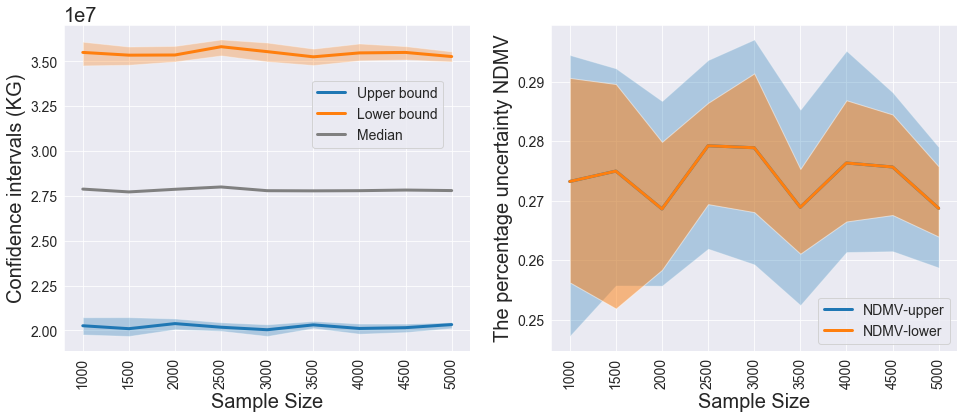

In [39]:

plt.rcParams.update({'font.size': 8})
fs=14
sns.set_style('darkgrid')
fig, axes = plt.subplots(1, 2)
ind = list(df.index)
df = df.loc[ind[0:9], :]
ind = list(df.index)
ax = df[cols[[0, 3]]].plot(figsize=(16, 6), ax=axes[0])
plt.sca(axes[0])
df[cols[-1]].plot(ax=ax, color='grey')
plt.xticks(range(len(df.index)), df.index, rotation=90)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.fill_between(df.index, df[cols[1]], df[cols[2]], alpha=0.3)
ax.fill_between(df.index, df[cols[4]], df[cols[5]], alpha=0.3)
ax.set_xlabel('Sample Size');
ax.set_ylabel('Confidence intervals (KG)');
ax.legend(['Upper bound', 'Lower bound', 'Median'], bbox_to_anchor=[0.95, 0.85], fontsize=fs)

ax1 = df_ratio.loc[ind, cols[[0, 3]]].plot(ax=axes[1])
plt.sca(axes[1])
plt.xticks(range(len(df.index)), df_ratio.index[0:9], rotation=90)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.fill_between(df.index, df_ratio.loc[ind, cols[4]], df_ratio.loc[ind, cols[5]], alpha=0.3)
ax1.fill_between(df.index, df_ratio.loc[ind,cols[1]], df_ratio.loc[ind, cols[2]], alpha=0.5)
ax1.set_xlabel('Sample Size');
ax1.set_ylabel('The percentage uncertainty NDMV');
ax1.legend(['NDMV-upper', 'NDMV-lower'], loc='lower right', fontsize=fs);
plt.savefig('../output/paper0915/figure/'+'conf_adaptive_two_panels_5000.png', format='png', dpi=300, layout='tight')